#Visualizing Your Playlists
Conor Carmichael
---
---
In this notebook, I will create visualizations on the playlists and listening habits of the user.

##Setup

In [0]:
#Install dependencies
!pip install spotipy
!pip install scipy

In [0]:
#Import basic packages
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib as mpl
import numpy as np
import pandas as pd
from scipy.interpolate import make_interp_spline, BSpline
from scipy.ndimage.filters import gaussian_filter1d

from collections import Counter

import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.oauth2 as oauth2

In [0]:
# Get client access information
client_id = "90f77865b99144d99cf6542eacad164c" 
client_secret = "fb349f0f7ac54fa2b39019739c615e0f"


In [0]:
# Authorization
credentials = oauth2.SpotifyClientCredentials(
        client_id=client_id,
        client_secret=client_secret)

token = credentials.get_access_token()
spotify = spotipy.Spotify(auth=token)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: You're using 'as_dict = True'.get_access_token will return the token string directly in future versions. Please adjust your code accordingly, or use get_cached_token instead.
  


##Setting the defaults for matplotlib

In [0]:
# #Global Setting variables
text_color = (0.9, 0.9, 0.9)


mpl.rcParams['axes.facecolor'] = (0.09,0.09,0.09)
mpl.rcParams['axes.labelcolor'] = (0.85, 0.85, 0.85)
mpl.rcParams['xtick.color'] = text_color
mpl.rcParams['ytick.color'] = text_color
mpl.rcParams['axes.titlesize'] = 'large'

mpl.rcParams['font.size'] = 16

mpl.rcParams['figure.facecolor'] = (0.25,0.25,0.25)
mpl.rcParams['figure.figsize'] = [20, 12]

# mpl.rcParams['legend.fontsize'] = 'large'

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["limegreen", "dimgrey", "mediumturquoise", "mediumorchid", "snow", "lemonchiffon","tomato","olive","aqua"]) 

In [0]:
# mpl.rcParams.keys()

##Functions for retrieving/preprocessing data

In [0]:
def normalize(arr):
    mx = max(arr)
    mn = min(arr)
    for ind, val in enumerate(arr):
        arr[ind] = (val - mn) / (mx-mn)
    return arr

def smooth(X,Y, factor=300):
    mn, mx = min(X), max(X)
    x_new = np.linspace(mn, mx, factor)
    a_BSpline = make_interp_spline(X, Y)
    y_new = a_BSpline(x_new)

    return (x_new, y_new)

In [0]:
def filter_for_personal_playlists(playlists, username):
    filtered = []
    for P in playlists:
        if username == P['owner']['display_name']:
            filtered.append(P)
    return filtered

def track_retrieval(spotify, pl_id, total_songs, track_limit):
    track_list, audio_feat_list = [], []
    offset = 0
    while offset < total_songs:
        track_batch = spotify.playlist_tracks(pl_id, limit=str(track_limit), offset=str(offset))['items']
        track_list += track_batch

        track_ids = [t['track']['id'] for t in track_batch]
        audio_feat_batch = spotify.audio_features(track_ids)
        audio_feat_list += audio_feat_batch

        offset = offset + track_limit

    return track_list, audio_feat_list

def get_playlist_tracks(spotify, playlists):
    track_limit = 100
    for P in playlists:
        print('Retrieving: ',P['name'])
        P['track_list'], P['track_audio_features'] = track_retrieval(spotify, P['id'], P['tracks']['total'], track_limit)


In [0]:
def create_playlist_df(p):
    columns = ['track_id','title','album','artist','danceability', 'energy', 
        'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 
        'liveness', 'valence', 'tempo', 
        'duration_ms', 'time_signature'
    ]
    rows = []
    for i in range(p['tracks']['total']):
        T = p['track_list'][i]['track']
        row = [T['id'], T['name'], T['album']['name'],
               T['album']['artists'][0]['name']  
            ]
        row += p['track_audio_features'][i].values()
        del row[17]
        del row[17]
        del row[17]
        del row[15]
        del row[15]
        rows.append(row)
    df = pd.DataFrame(rows, columns=columns)
    # playlist_dataframes[p['id']]['df'] = df
    return df

##Getting your Spotify playlist information

##Enter your Username:

In [0]:
# username = input('What is your Spotify username, so that we can gather playlist information?\n')
username = "12133127381" # My username is just a string of digits

In [0]:
#Getting data from Spotify
print('Retrieving your playlists...\n')
playlists_return = spotify.user_playlists(username, limit=50) # Access Spotify API

playlists = playlists_return['items'] # The playlist information: Important keys: id, name,

playlists = filter_for_personal_playlists(playlists, username)

print('Getting the tracks and audio features for the playlists...')
get_playlist_tracks(spotify, playlists)


#Convenience
map_name_ide = {P['name']:P['id'] for P in playlists}
map_id_name = {P['id']:P['name'] for P in playlists}
playlist_names = [P['name'] for P in playlists]

#Wrap up all the dataframes
playlist_dataframes = {p['id']:{'name':p['name'], 'df':None} for p in playlists}

print('\nProcessing data into tables.')
for p in playlists:
    df = create_playlist_df(p)
    playlist_dataframes[p['id']]['df'] = df
print('Data processed into tables.')


Retrieving your playlists...

Getting the tracks and audio features for the playlists...
Retrieving:  NPR Top 2010s
Retrieving:  Chili peppers jam track
Retrieving:  RHCP
Retrieving:  Modest Mouse
Retrieving:  VW 1975
Retrieving:  JF+RHCP
Retrieving:  Oasis/Liam/Noel
Retrieving:  TAME EVERYTHING
Retrieving:  Bloc Party @House of Blues
Retrieving:  RHCP LIVE FEB 7 17
Retrieving:  Twenty One Pilots- Gilford, NH
Retrieving:  Everything Everything 8/03/16 @ The Sinclaire
Retrieving:  fall 2016 similar
Retrieving:  fall 2016
Retrieving:  Fall
Retrieving:  Spring
Retrieving:  Meta Pregame 05/08
Retrieving:  Meta Pregame
Retrieving:  main()
Retrieving:  NYE 2019
Retrieving:  Hangover Cure
Retrieving:  Country
Retrieving:  14 y.o. me gaming would listen to:
Retrieving:  Rap/Pop assemblance
Retrieving:  Kind Vibes
Retrieving:  Workout
Retrieving:  gaming
Retrieving:  Starred
Retrieving:  Study

Processing data into tables.
Data processed into tables.


In [0]:
playlist_dataframes[map_name_ide['VW 1975']]['df'].describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000
mean,0.530064,0.589307,5.235772,-8.292740,0.918699,0.070240,0.330856,0.092234,0.178654,0.464304,120.154772,218384.154472,3.910569
std,0.183829,0.230735,3.875271,3.753144,0.274414,0.063334,0.340758,0.227111,0.134646,0.291324,31.166560,71142.913798,0.496019
min,0.081900,0.013300,0.000000,-22.001000,0.000000,0.024200,0.000002,0.000000,0.043300,0.033100,60.440000,74750.000000,1.000000
25%,0.397500,0.425000,2.000000,-10.068000,1.000000,0.037000,0.018650,0.000050,0.091150,0.178000,99.524000,176017.500000,4.000000
50%,0.541000,0.612000,5.000000,-7.104000,1.000000,0.049900,0.209000,0.001160,0.127000,0.472000,113.483000,221600.000000,4.000000
75%,0.663000,0.781500,9.000000,-5.603500,1.000000,0.067800,0.631000,0.018850,0.204500,0.712000,137.991500,252053.500000,4.000000
max,0.890000,0.975000,11.000000,-3.285000,1.000000,0.403000,0.972000,0.983000,0.789000,0.974000,207.969000,591160.000000,5.000000


##Code for generating plots

Make plots smoother

###Histogram of Key for songs in a playlist

In [0]:
def personalized_hist_values(playlist_df, keys, dots_per_row, bin_radius):
    #make tuple- (X, Y, color_ind)
    tuples = []
    step = (bin_radius*2) / dots_per_row # Where to position on x axis, side by side for same key
    for key in keys:
        subset = playlist_df[playlist_df['key']==key]['key'].values
        subset_mode = playlist_df[playlist_df['key']==key]['mode'].values

        for index in range(len(subset)):
            x = (key - bin_radius) + (index % dots_per_row)*step
            y = int(index / dots_per_row)
            c = subset_mode[index]
            tuples.append([x, y, c])

    return np.array(tuples)

def plot_songs_by_key(playlist_df, name, dots_per_row=5, bin_radius=0.4):
    #return axes
    fig, ax = plt.subplots()

    bins = [0,1,2,3,4,5,6,7,8,9,10,11]
    x_labels = ['C', 'C#','D','D#','E','F','F#','G','G#','A','A#','B']
    legend = ['Minor','Major']

    plot_values = personalized_hist_values(playlist_df, bins, dots_per_row, bin_radius)
    print('{} Songs Plotted.'.format(len(plot_values)))
    minor = plot_values[plot_values[:,2]==0]
    major = plot_values[plot_values[:,2]==1]
    
    for mode_data, label, color in zip([major,minor], ['Major','Minor'], ['limegreen','dimgrey']):
        ax.scatter(mode_data[:,0], mode_data[:,1], c=color, s=100, 
            label=label)
        
    ax.plot([], [], ' ', label='One dot per track\n\n{} Major, {} Minor'.format(len(major), len(minor)))

    #Axes
    ax.set_xticks(bins)
    ax.set_xticklabels(x_labels)

    max_y = max(plot_values[:, 1])
    max_y = max(max_y, 4)
    y = np.arange(0,max_y+1,1)
    ax.set_yticks(y)
    y_labels = ["{}-{}".format(int(v)*dots_per_row+1, int(v*dots_per_row+dots_per_row)) for v in y]
    ax.set_yticklabels(y_labels)

    ax.set_xlabel("Song Key")
    ax.set_ylabel('Count')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_title('Distribution of Keys in Your {} Playlist'.format(name))

    return ax

###Differences Across Playlists

In [0]:
def plot_avgs_per_playlist(dfs, years):
    fig, ax = plt.subplots()

    descriptions = [df.describe() for df in dfs]
    means = [d.iloc[1].values for d in descriptions]
    X = np.arange(0, len(dfs), 1)
    mean_dance = [m[0] for m in means]
    mean_duration = normalize([m[11] for m in means])
    mean_energy = [m[1] for m in means]
    mean_speechiness = [m[5] for m in means]
    mean_tempo = normalize([m[10] for m in means])
    mean_acousticness = [m[6] for m in means]

    x, y = smooth(X, mean_dance)
    ax.plot(x, y, label='Danceability')

    x, y = smooth(X, mean_energy)
    ax.plot(x, y, label='Energy')

    x, y = smooth(X, mean_speechiness)
    ax.plot(x, y, label='Speechiness')

    x, y = smooth(X, mean_tempo)
    ax.plot(x, y, label='* Tempo')

    x, y = smooth(X, mean_duration)
    ax.plot(x, y, label='* Duration')

    x, y = smooth(X, mean_acousticness)
    ax.plot(x, y, label='Acousticness')


    ax.set_title('Trends in [mean] Audio Features Over the Years')
    ax.set_xticks([0,1,2,3])
    ax.set_xticklabels(['2016','2017','2018','2019'])
    ax.legend()
    ax.set_xlabel('Your Top Songs of: ')
    ax.set_ylabel('Mean Value on [0,1] Range')
    ax.text(0.75,0.8, "*Mean Values are normalized\nto a [0, 1] range.")
    return ax


In [0]:
def averages_across_playlists(playlist_collection, categories, smoothing_factor=300, playlist_as_x=True):
    fig, ax = plt.subplots()

    X = np.arange(1,len(playlist_collection)+1)
    playlist_names = []
    DATA = np.zeros((len(categories), len(playlist_collection)))

    for playlist_num, P in enumerate(playlist_collection):
        df = playlist_collection[P]['df']
        desc = df.describe()[categories]
        means = desc.iloc[1].values
        name = playlist_collection[P]['name']
        name = name if len(name) < 20 else name[:20]+'...'
        playlist_names.append(name)

        for categ_num, m in enumerate(means):
            DATA[categ_num, playlist_num] = m

    if playlist_as_x:

        for ind, row in enumerate(DATA):
            x, y = smooth(X, row, factor=smoothing_factor)
            ax.plot(x, y, label=categories[ind])

        ax.set_xticks(X)
        X_LABELS = playlist_names
        ax.set_xticklabels(X_LABELS, rotation=80)
        ax.legend()

    else:
        X = np.arange(0,len(categories)) # Change labelling
        X_LABELS = categories
        

        for ind, row in enumerate(DATA.T):
            x, y = smooth(X, row, factor=smoothing_factor)
            ax.plot(x, y, label=playlist_names[ind])

        ax.set_xticks(X)
        ax.set_xticklabels(X_LABELS, rotation=0)
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ax.set_title('Difference Between Playlists')
    return ax

In [0]:
def check_common_tracks(dfs):
    sets = [set(df['track_id'].values) for df in dfs]
    common = set.intersection(*sets)    
    return common    

###Artist Occurence Across Playlists

In [0]:
def plot_artist_commonality(playlist_collection, num=10):
    # Create Counter object, iterate over the artist column for each playlist
    fig, ax = plt.subplots()

    artist_count = Counter()
    all_artists= []
    for p in playlist_collection:
        df = playlist_collection[p]['df']
        for a in df['artist'].values:
            artist_count[a] += 1

    artist_count = artist_count.most_common(num)

    artists = [p[0] for p in artist_count][::-1]
    counts = [p[1] for p in artist_count][::-1]
    
    ax.barh(artists, counts)
    
    ax.set_title('{} Most Common Artists Across All Playlists'.format(num))

    return (ax, artists, counts)


In [0]:
def generate_points_sizes(rank, prev_point):
    r = ((1/2)**rank)*10
    x = prev_point[0] + (np.random.random_sample()-0.5) * r
    y = prev_point[1] + (np.random.random_sample()-0.5) * r
    point = [x,y]
    return [point, r]

def bubble_chart(artists, occurences):
    # Need points, and radius values, then can use scatter
    fig, ax = plt.subplots()
    ranks, points =  [], []
    prev=[0,0]
    for i in range(len(artists)):
        p, r = generate_points_sizes(i, prev)
        prev = p
        ranks.append(r)
        points.append(p)

    points = np.array(points).reshape((len(artists),2))
    ax.scatter(points[:,0], points[:,1], s=ranks)
    ax.set_xticks(np.arange(-1,1, 0.1))
    ax.set_yticks(np.arange(-1,1, 0.1))

    return ax

#See What Keys are Most Frequent:
Run these cells, and choose your playlist!

In [0]:
import ipywidgets as widgets
disp_options = widgets.Dropdown(options=playlist_names, value=playlist_names[0])
disp_options

Dropdown(options=('NPR Top 2010s', 'Chili peppers jam track', 'RHCP', 'Modest Mouse', 'VW 1975', 'JF+RHCP', 'O…

500 Songs Plotted.


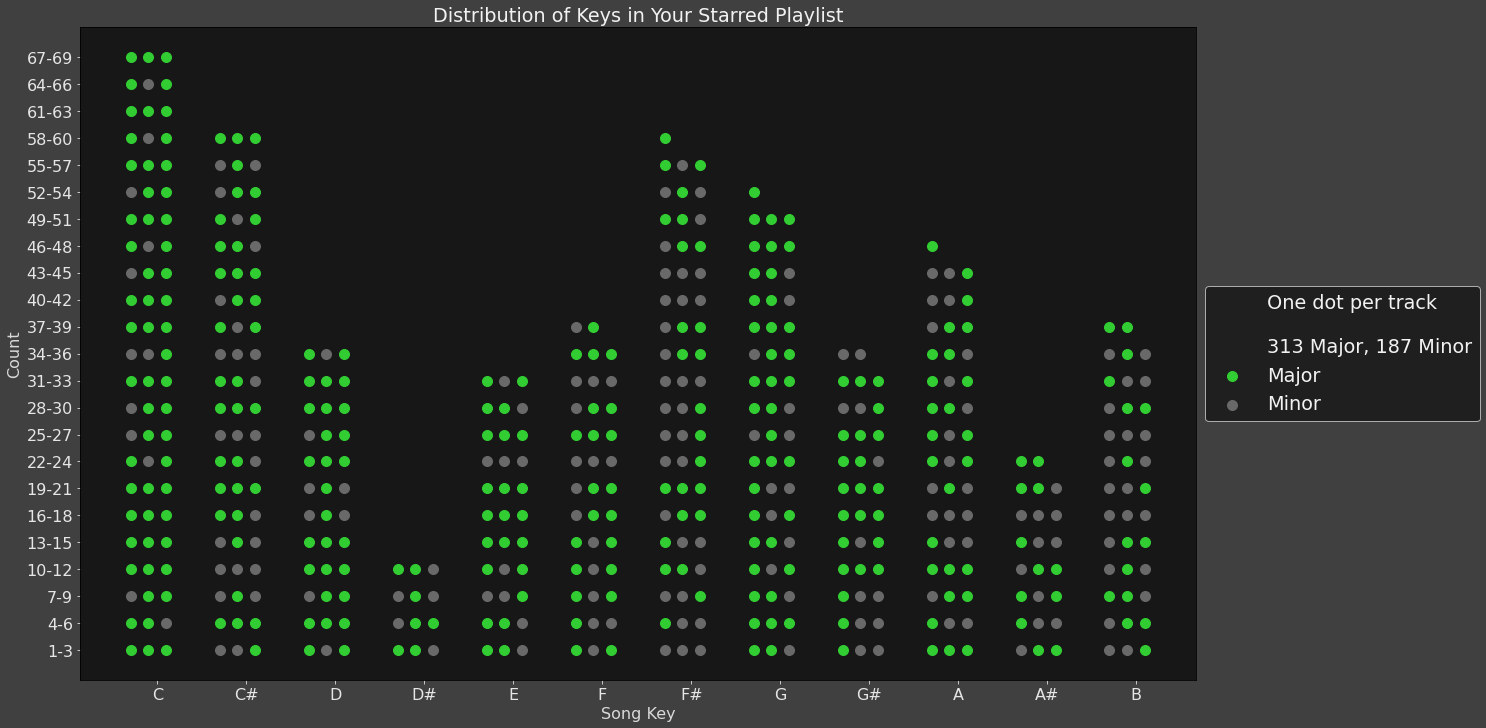

In [0]:
playlist_id = map_name_ide[disp_options.value]
ax = plot_songs_by_key(playlist_dataframes[playlist_id]['df'], 
                       disp_options.value,
                       dots_per_row=3, 
                       bin_radius=0.3)
plt.show()

#Which artists show up the most?

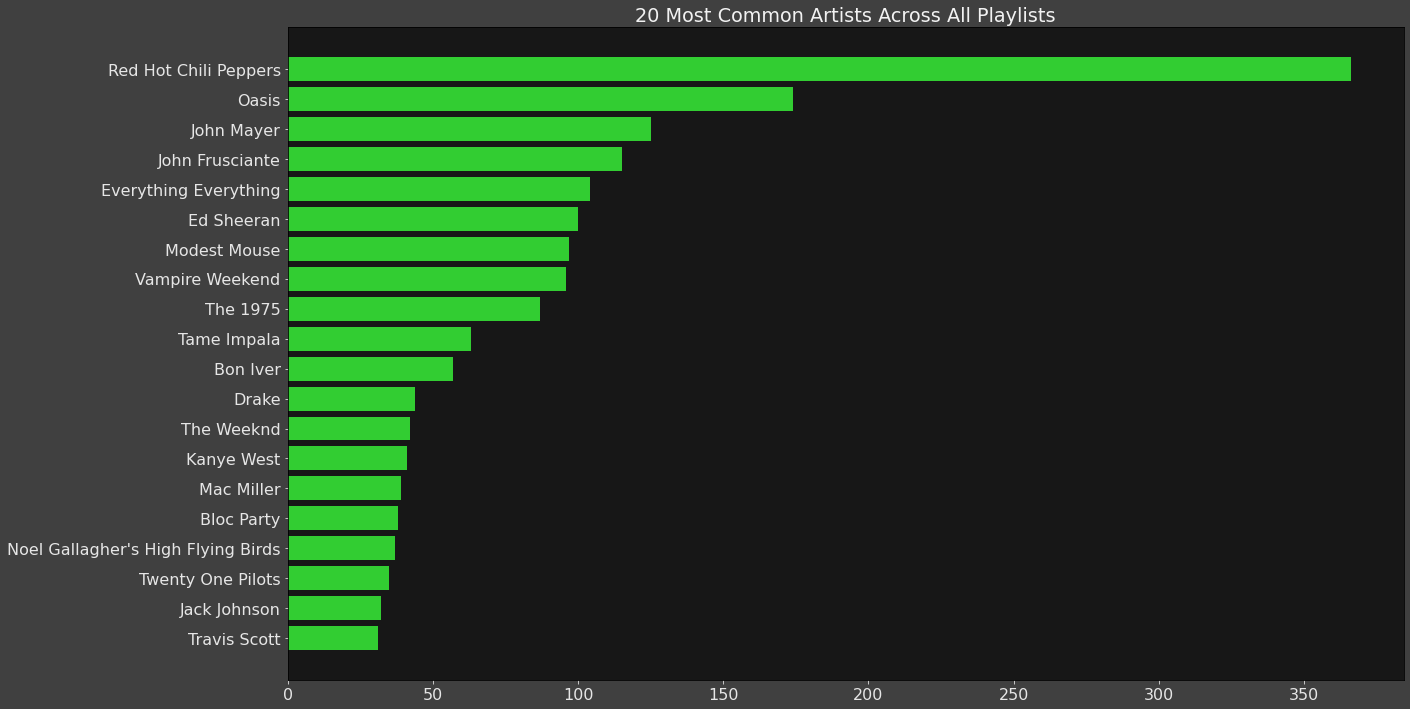

In [0]:
ax, artists, counts = plot_artist_commonality(playlist_dataframes, 20)
plt.show()

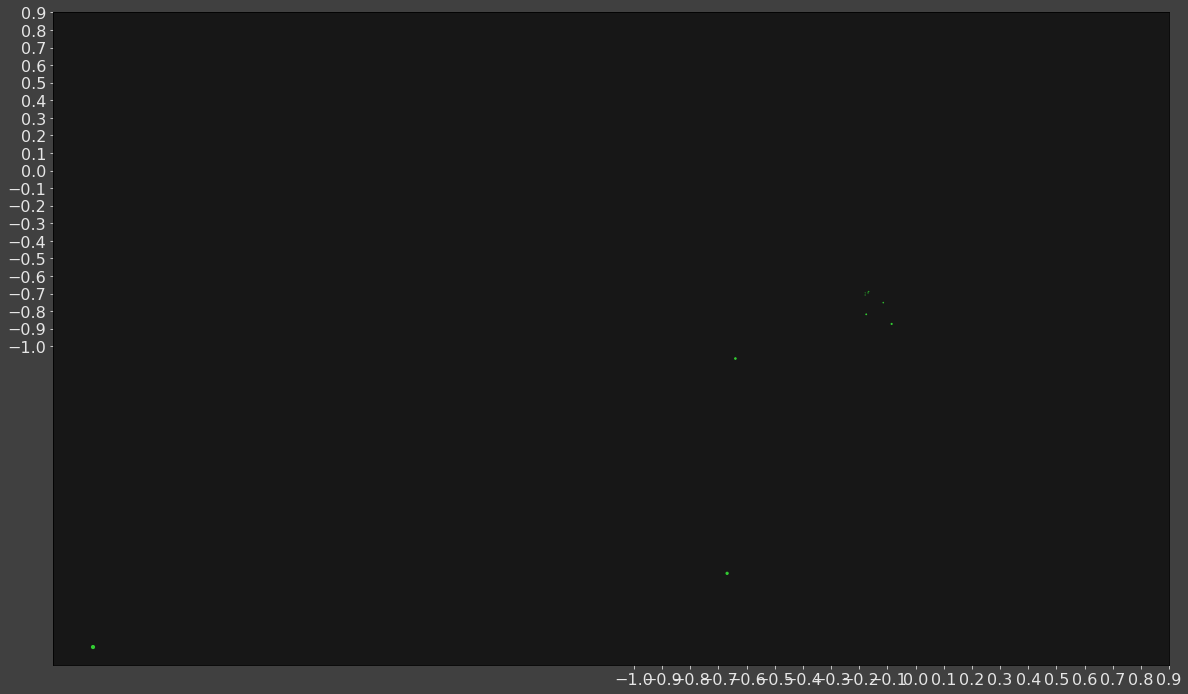

In [0]:
ax = bubble_chart(artists, counts)
plt.show()

#How do your playlists differ, statistcally?

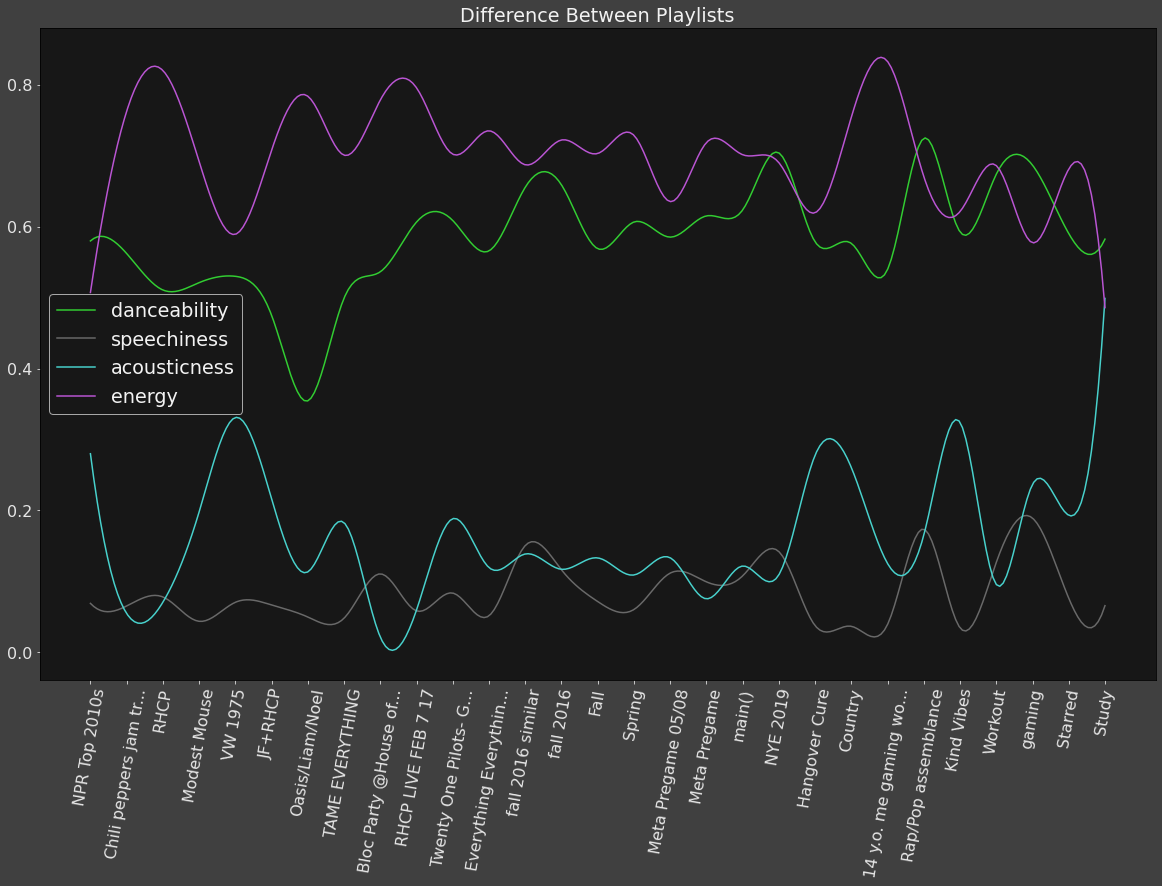

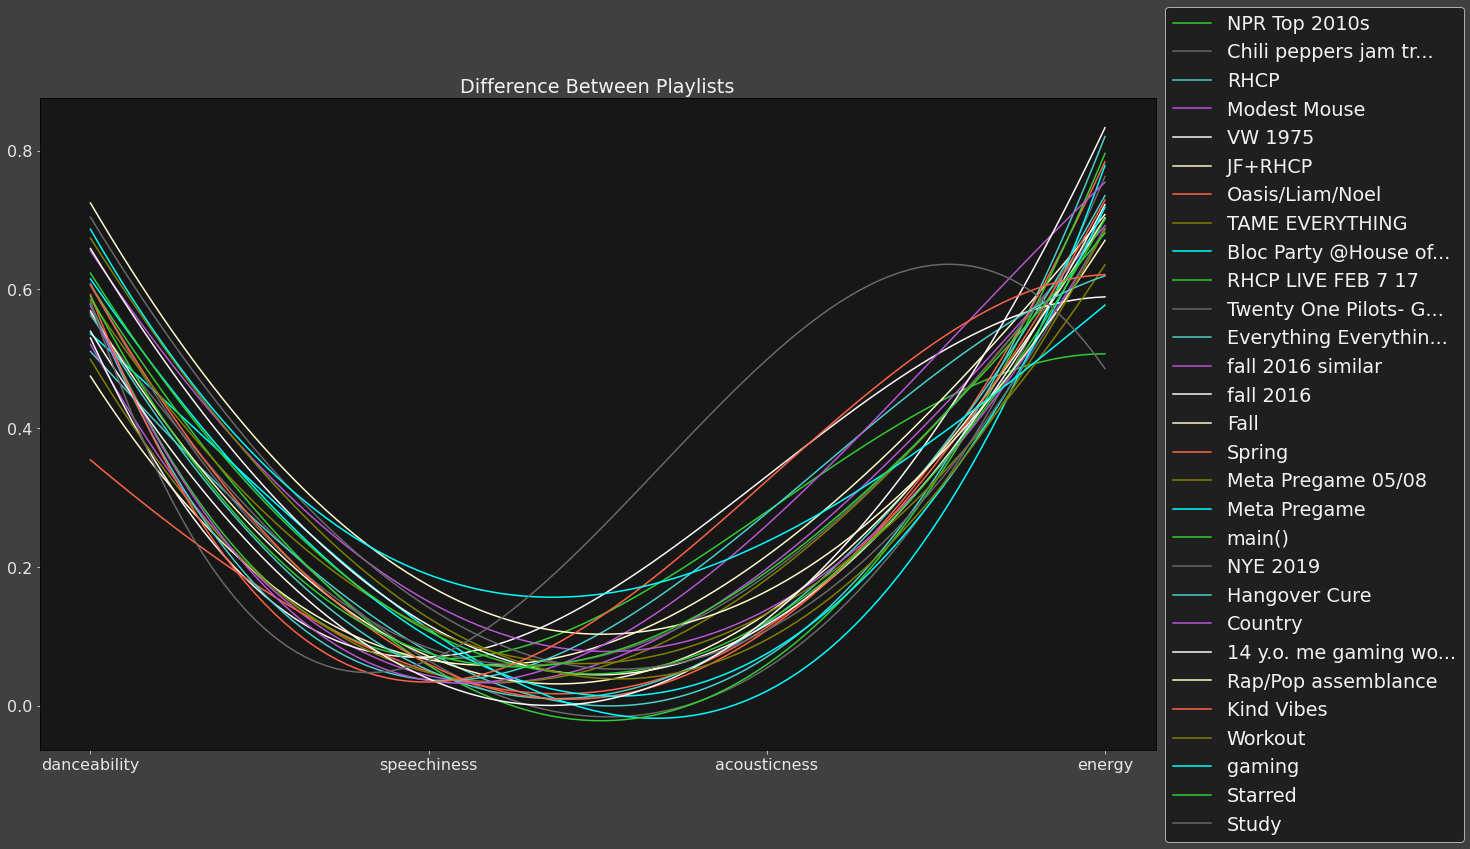

In [0]:
ax = averages_across_playlists(playlist_dataframes, ['danceability','speechiness','acousticness', 'energy'], 300, playlist_as_x=True)
ax = averages_across_playlists(playlist_dataframes, ['danceability','speechiness','acousticness', 'energy'], 100, playlist_as_x=False)

plt.show()
#Smoothing broken RN

#How has your listening changed over the years?

Enter in the playlist id's for the "Your Top Songs of 20__" to get insights!

To get the playlist ID:
*  Go to the playlist on Spotify
*  Click share->Copy Spotify URI
*  Paste somewhere
    * Will look like this: `spotify:playlist:37i9dQZF1EteaOVHVCDo6o`
*  Copy the ID from the link
    * Everything after `spotify:playlist`:
    * So, `37i9dQZF1EteaOVHVCDo6o`
* Paste in the respective form field

In [0]:
#@title Enter the playlist id for your "Your Top Songs ____" playlists. { display-mode: "form" }


Your_Top_Songs_2016 = '37i9dQZF1CyZ4j7ZmZmc7G'  #@param {type: "string"}
Your_Top_Songs_2017 = '37i9dQZF1E9KxKjnkWqrNk'  #@param {type: "string"}
Your_Top_Songs_2018 = '37i9dQZF1EjwWYQpi2BQM6'  #@param {type: "string"}
Your_Top_Songs_2019 = '37i9dQZF1EteaOVHVCDo6o'  #@param {type: "string"}
top_songs_pl_ids = [Your_Top_Songs_2016,Your_Top_Songs_2017,Your_Top_Songs_2018,Your_Top_Songs_2019]

###Fetching data for the above inputted playlists

In [0]:
playlists_yts = [] #playlist objects
for yts in top_songs_pl_ids: #iterate over list of ids
    if yts != 'input playlist id here':
        # Get playlist
        P = spotify.playlist(yts) # get playlist by id
        playlists_yts.append(P)

# Get tracks and audio features
get_playlist_tracks(spotify, playlists_yts) #iterate over the playlist objets and get the plauylsit tracks

# Gen DF
dfs = []
your_top_songs_info = {p['id']:{'name':p['name'], 'df':None} for p in playlists_yts} # ID is first key, to acess the name and then the dataframe
for P in playlists_yts:
    df = create_playlist_df(P)
    dfs.append(df)
    your_top_songs_info[P['id']]['df'] = df

Retrieving:  Your Top Songs 2016
Retrieving:  Your Top Songs 2017
Retrieving:  Your Top Songs 2018
Retrieving:  Your Top Songs 2019


In [0]:
ids = list(check_common_tracks([
    your_top_songs_info[i]['df'] for i in top_songs_pl_ids
]) )
df = your_top_songs_info['37i9dQZF1CyZ4j7ZmZmc7G']['df']
songs_from_all_years = ""

for ind, id in enumerate(ids):
    track = df[df['track_id'] == id][['title','artist']].values[0]
    songs_from_all_years+="{}) {} by {}\n ".format(ind+1, track[0],track[1])


### Your Top Songs Trends

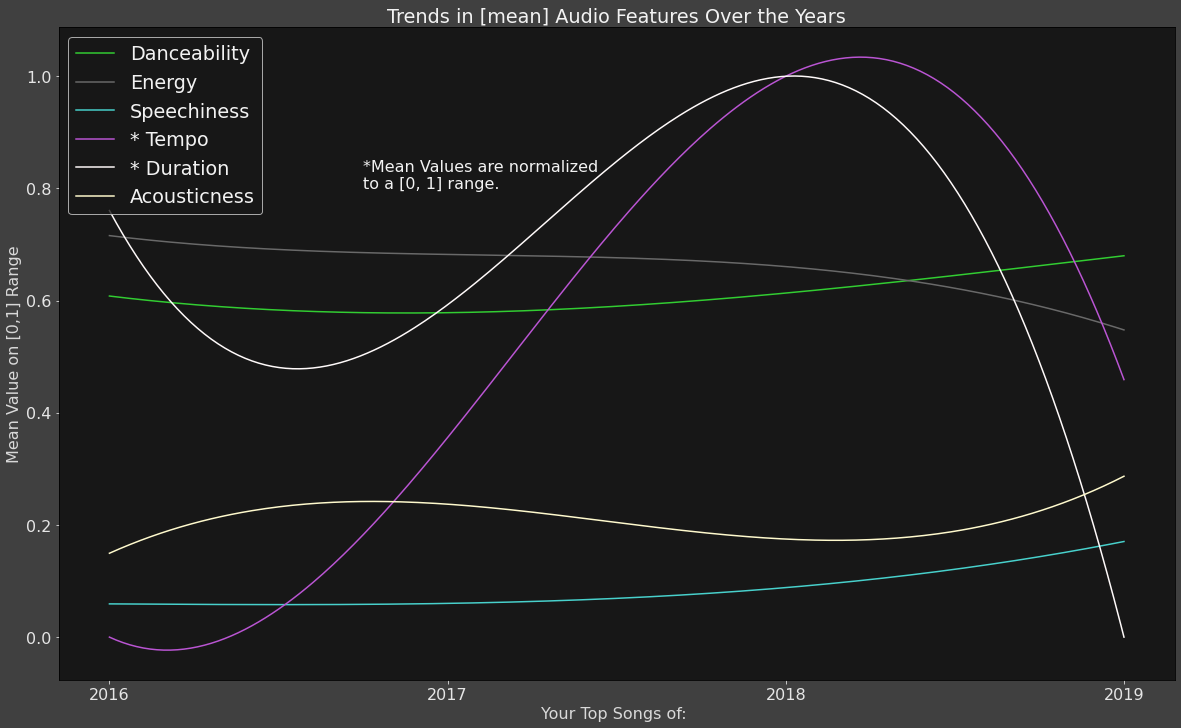

*Mean Values are normalized to a [0, 1] range.

You have had the following songs on your most listened list for all years:

1) Sweater Weather by The Neighbourhood
 


In [0]:
ax = plot_avgs_per_playlist(dfs, None)
plt.show()
print("*Mean Values are normalized to a [0, 1] range.")
print("\nYou have had the following songs on your most listened list for all years:\n")
print(songs_from_all_years)